In [65]:
import numpy as np
import matplotlib.pyplot as plt
from ard.offshore.mooring_constraint import (
    distance_point_to_mooring,
    distance_mooring_to_mooring,
)
from ard.utils import smooth_min

N_turbines = 6
D_rotor = 130.0

np.random.seed(0)
P_turbines = 20 * D_rotor * np.random.normal(size=(N_turbines, 2))
psi_platform = np.random.uniform(0.0, 2 * np.pi, N_turbines)


def get_platform_points(P_turbine_vec, psi_vec):
    P_moorings = []
    for point_turbine, psi_platform in zip(P_turbine_vec, psi_vec):
        L_mooring = 5 * D_rotor
        xP0 = point_turbine[0]
        yP0 = point_turbine[1]
        xP1 = point_turbine[0] + np.cos(psi_platform + np.pi) * L_mooring
        yP1 = point_turbine[1] + np.sin(psi_platform + np.pi) * L_mooring
        xP2 = point_turbine[0] + np.cos(psi_platform + 5 / 3 * np.pi) * L_mooring
        yP2 = point_turbine[1] + np.sin(psi_platform + 5 / 3 * np.pi) * L_mooring
        xP3 = point_turbine[0] + np.cos(psi_platform + 7 / 3 * np.pi) * L_mooring
        yP3 = point_turbine[1] + np.sin(psi_platform + 7 / 3 * np.pi) * L_mooring
        P_moorings.append(
            [
                [xP0, yP0],
                [xP1, yP1],
                [xP2, yP2],
                [xP3, yP3],
            ]
        )
    return np.array(P_moorings)


P_moorings = get_platform_points(P_turbines, psi_platform)
print(P_moorings)

[[[ 4586.53609952  1040.40874175]
  [ 5178.02954479  1309.91848962]
  [ 4057.38708866  1417.90221761]
  [ 4524.19166509   393.40551804]]

 [[ 2544.71875867  5826.32231792]
  [ 1964.46234562  6119.24294728]
  [ 2581.17025889  5177.34520883]
  [ 3088.52367152  6182.37879766]]

 [[ 4855.65077439 -2540.92248768]
  [ 4269.32725389 -2821.50176223]
  [ 5391.80131418 -2908.403914  ]
  [ 4905.82375511 -1892.86178681]]

 [[ 2470.22988557  -393.52874157]
  [ 1915.22423765  -731.86102023]
  [ 3040.73705776  -705.01159259]
  [ 2454.72836129   256.28638809]]

 [[ -268.36901466  1067.55610504]
  [ -913.13117235   985.20466297]
  [  125.33050506   550.35141812]
  [  -17.30637669  1667.11223403]]

 [[  374.51328502  3781.1111181 ]
  [   52.04008353  4345.4789364 ]
  [   46.99301804  3219.65722443]
  [ 1024.50675348  3778.19719348]]]


In [66]:
X, Y = np.meshgrid(
    np.linspace(
        np.min(P_moorings[:, :, 0]) - 4250.0, np.max(P_moorings[:, :, 0]) + 4250.0, 201
    ),
    np.linspace(
        np.min(P_moorings[:, :, 1]) - 2250.0, np.max(P_moorings[:, :, 1]) + 2250.0, 201
    ),
)
D = np.zeros_like(X)
D_pure = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(Y.shape[1]):
        distances = np.zeros(N_turbines)
        for k in range(N_turbines):
            distances[k] = distance_point_to_mooring(
                np.array([X[i, j], Y[i, j]]), P_moorings[k, :, :]
            )

        D[i, j] = smooth_min(distances)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


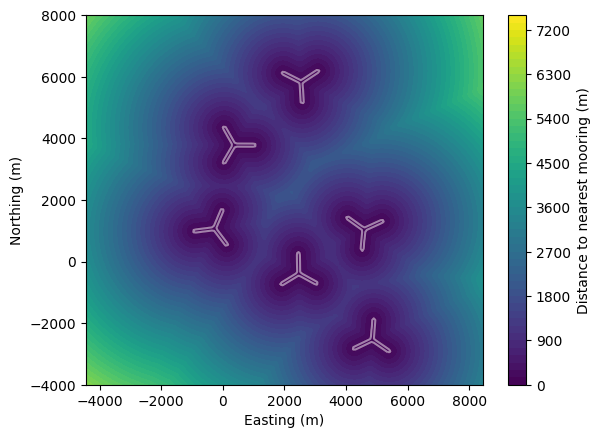

In [67]:
cnt = plt.contourf(X, Y, D, levels=51)
cnt.set_edgecolor("face")
plt.colorbar(label="Distance to nearest mooring (m)")
plt.contour(X, Y, D, levels=51, colors="black", linewidths=0)
plt.contour(X, Y, D, levels=[51.0], colors="w", alpha=0.5)
plt.axis("equal")

plt.ylim([-4000, 8000])
plt.xlim([-4000, 8000])

plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")

plt.savefig("mooring_distance.pdf", transparent=True)

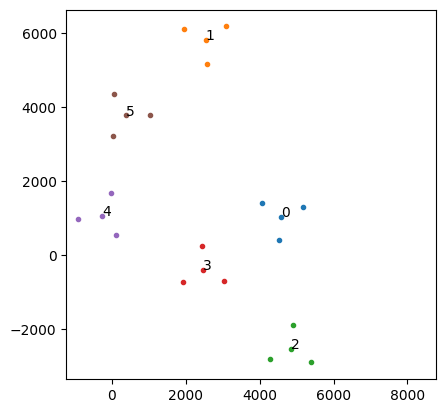

In [68]:
for i_turb in range(P_moorings.shape[0]):
    plt.text(P_turbines[i_turb, 0], P_turbines[i_turb, 1], i_turb)
    plt.plot(P_moorings[i_turb, :, 0], P_moorings[i_turb, :, 1], ".")
plt.axis("square");

In [69]:
for i in [
    2,
]:  # range(P_moorings.shape[0]):
    for j in range(P_moorings.shape[0]):
        if i == j:
            continue
        print(
            i,
            j,
            distance_mooring_to_mooring(P_moorings[i, :, :], P_moorings[j, :, :]),
        )

2 0 2317.9001793379816
2 1 7442.569505129609
2 3 2211.2285304725006
2 4 5342.47987226055
2 5 6872.082400961983


In [70]:
# test timing
def calc_moorings():
    for i in range(0, P_moorings.shape[0] - 1):
        for j in range(P_moorings.shape[0]):
            if i == j:
                continue
            distance_mooring_to_mooring(P_moorings[i, :, :], P_moorings[j, :, :])


from timeit import timeit

calc_moorings()
total_time = timeit(calc_moorings, number=100)
time_per_run = total_time / 100

print("Total: ", total_time)
print("Per run: ", time_per_run)

# calc_mooring_distances(P_moorings)
# total_time = timeit(calc_mooring_distances, number=100)
# time_per_run = total_time/100

# print("Total: ", total_time)
# print("Per run: ", time_per_run)

Total:  1.0109518340032082
Per run:  0.010109518340032082


# Smooth Norm

In [71]:
from jax import grad
from jax import numpy as jnp


def smooth_norm(vec: np.ndarray, buf=1e-12):
    return jnp.sqrt(buf**2 + jnp.sum(vec**2))  # - np.sqrt(buf**2)


smooth_norm_grad = grad(smooth_norm, [0])


def norm(vec: np.ndarray):
    return jnp.linalg.norm(vec)


norm_grad = grad(norm, [0])

In [72]:
base_vec = np.array([0, 0])
dif_vals = np.arange(-1e-10, 1e-10, 1e-13)
result = np.zeros_like(dif_vals)
result_smooth = np.zeros_like(dif_vals)
result_grad = np.zeros_like(dif_vals)
result_smooth_grad = np.zeros_like(dif_vals)
for i, v in enumerate(dif_vals):
    result_smooth[i] = smooth_norm(np.array([v, 0.0]))
    result[i] = norm(np.array([v, 0.0]))
    result_smooth_grad[i] = smooth_norm_grad(jnp.array([v, 0.0]))[0][0]
    result_grad[i] = norm_grad(jnp.array([v, 0.0]))[0][0]

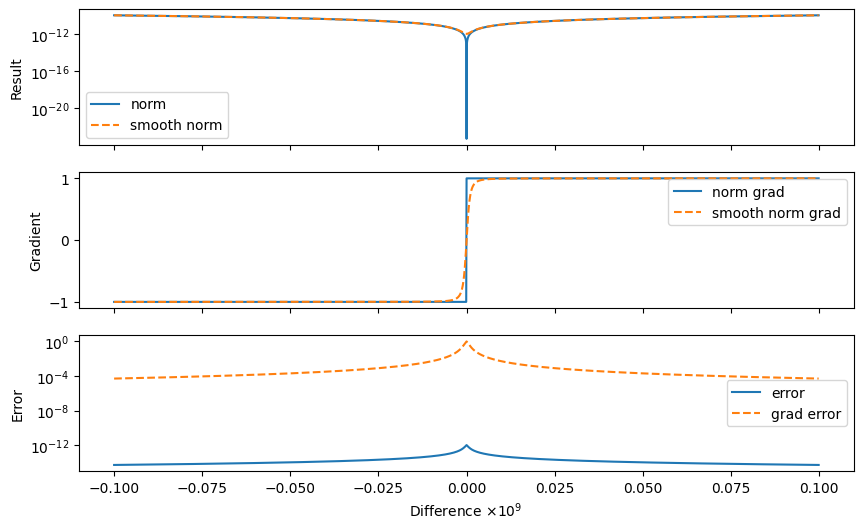

In [73]:
fig, ax = plt.subplots(3, 1, figsize=(10, 6), sharex=True)
ax[0].plot(dif_vals * 1e9, result, label="norm")
ax[0].plot(dif_vals * 1e9, result_smooth, "--", label="smooth norm")
ax[0].set(ylabel="Result", yscale="log", xscale="linear")
ax[0].legend()

ax[1].plot(dif_vals * 1e9, result_grad, label="norm grad")
ax[1].plot(dif_vals * 1e9, result_smooth_grad, "--", label="smooth norm grad")
ax[1].legend()
ax[1].set(ylabel="Gradient")

ax[2].plot(dif_vals * 1e9, result_smooth - result, label="error")
ax[2].plot(
    dif_vals * 1e9, abs(result_smooth_grad - result_grad), "--", label="grad error"
)
ax[2].legend()
ax[2].set(ylabel="Error", yscale="log", xlabel="Difference $\\times 10^9$ ")
plt.savefig("smooth_norm.pdf", transparent=True)